In [1]:
! pip install pyts

     |████████████████████████████████| 2.5MB 8.7MB/s 


In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

import matplotlib.pyplot as plt
import time
import copy

In [3]:
data = pd.read_csv('./코스피.csv', encoding='cp949', thousands=',')
data

,일자,현재지수,대비,등락률(%),배당수익률(%),주가이익비율,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원)
0,2001/01/02,520.95,16.33,3.24,2.37,15.89,0.00,503.31,521.34,500.97,231015,1223328,NaN
1,2001/01/03,521.43,0.48,0.09,2.37,15.89,0.00,512.74,524.58,510.70,324584,1583403,NaN
2,2001/01/04,558.02,36.59,7.02,2.22,16.99,0.00,551.53,567.16,550.91,444541,2984762,NaN
3,2001/01/05,580.85,22.83,4.09,2.13,17.69,0.00,559.54,581.41,555.40,578286,3569582,NaN
4,2001/01/08,586.65,5.80,1.00,2.11,17.87,0.00,573.72,587.91,572.48,558645,2948093,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4938,2020/12/23,2759.82,26.14,0.96,1.54,28.30,1.11,2737.74,2769.08,2716.28,1121347,20281218,1.901462e+09
4939,2020/12/24,2806.86,47.04,1.70,1.52,28.78,1.13,2762.60,2812.16,2762.60,1030890,19984695,1.936827e+09
4940,2020/12/28,2808.60,1.74,0.06,1.52,28.80,1.13,2820.95,2834.59,2799.56,1006250,24197781,1.938374e+09
4941,2020/12/29,2820.51,11.91,0.42,1.51,28.93,1.14,2810.55,2823.44,2792.06,1046839,19299049,1.944111e+09


In [4]:
df = data[['일자','현재지수','고가지수','저가지수']]
df.columns = ['Date','Close','High','Low']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.loc['2015-11-01':'2020-12-31']
df = df.astype(float)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,High,Low
Date,,,
2015-11-02,2035.24,2036.05,2028.20
2015-11-03,2048.40,2053.24,2040.75
2015-11-04,2052.77,2056.12,2042.38
2015-11-05,2049.41,2050.44,2039.93
2015-11-06,2041.07,2055.14,2038.46
...,...,...,...
2020-12-23,2759.82,2769.08,2716.28
2020-12-24,2806.86,2812.16,2762.60
2020-12-28,2808.60,2834.59,2799.56


In [5]:
# 이동평균
df['MA'] = df['Close'].rolling(window=15).mean()    # 당일 종가 포함

# 최근 5일간 Trend
for i in range(5):
    cond_B = (df['MA'].shift(i) >= df['MA'].shift(i+1))
    df[str(i+1)+'_Before'] = np.where(cond_B, 1, 0)
df['Before'] = df['1_Before'] + df['2_Before'] + df['3_Before'] + df['4_Before'] + df['5_Before']

# Trend 변수 ( Upward : 2, Box : 1, Downward : 0)
cond_T = ((df['Close'] >= df['MA']) & (df['Before'] == 5)) | ((df['Close'] < df['MA']) & (df['Before'] == 0))
cond_list = [((df['Close'] >= df['MA']) & (df['Before'] == 5)),
            ((df['Close'] < df['MA']) & (df['Before'] == 0))]
choice = [2, 0]
df['Trend'] = np.where(cond_T, np.select(cond_list, choice), 1)

df = df.loc['2016-01-01':'2020-12-31']
df

,Close,High,Low,MA,1_Before,2_Before,3_Before,4_Before,5_Before,Before,Trend
Date,,,,,,,,,,,
2016-01-04,1918.76,1954.52,1918.76,1963.881333,0,1,1,0,0,2,1
2016-01-05,1930.53,1937.57,1911.93,1962.445333,0,0,1,1,0,2,1
2016-01-06,1925.43,1934.25,1911.61,1960.899333,0,0,0,1,1,2,1
2016-01-07,1904.33,1926.41,1901.24,1959.333333,0,0,0,0,1,1,1
2016-01-08,1917.62,1918.25,1883.82,1958.310000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,2759.82,2769.08,2716.28,2750.106667,1,1,1,1,1,5,2
2020-12-24,2806.86,2812.16,2762.60,2757.482667,1,1,1,1,1,5,2
2020-12-28,2808.60,2834.59,2799.56,2762.626000,1,1,1,1,1,5,2


In [6]:
df['Before'].value_counts()

5    554
0    328
4     98
1     89
3     80
2     78
Name: Before, dtype: int64

In [7]:
df['Trend'].value_counts()

1    512
2    474
0    241
Name: Trend, dtype: int64

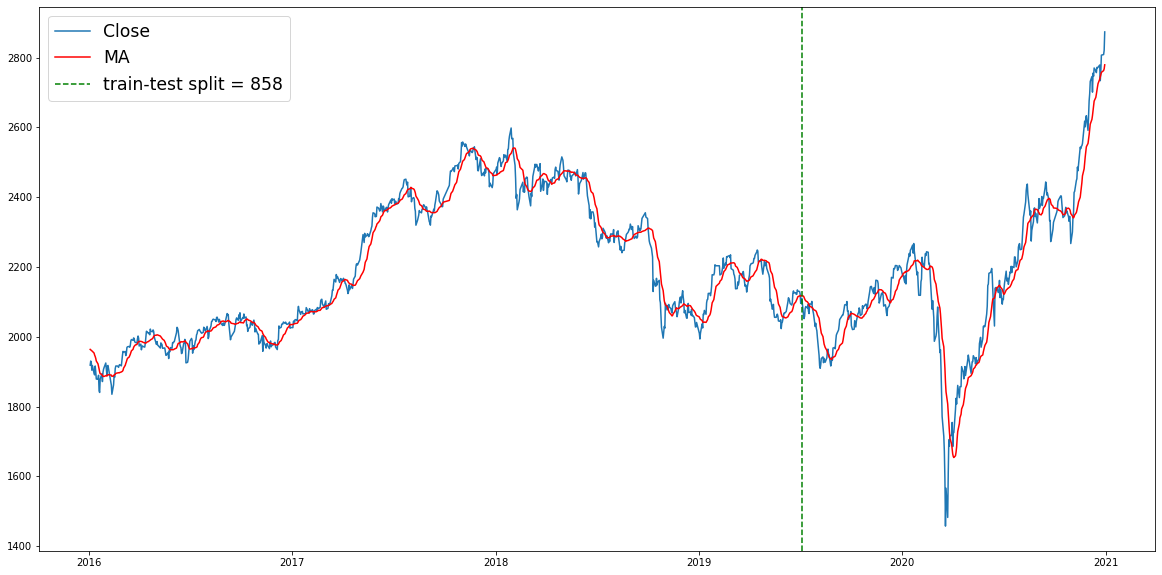

In [8]:
plt.figure(figsize=(20,10))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA'], color='red', label='MA')
plt.axvline(x=df.index[int(len(df)*0.7)], color='green', linestyle='--', 
            label='train-test split = '+ str(int(len(df)*0.7)))
plt.legend(fontsize='xx-large')
plt.show()

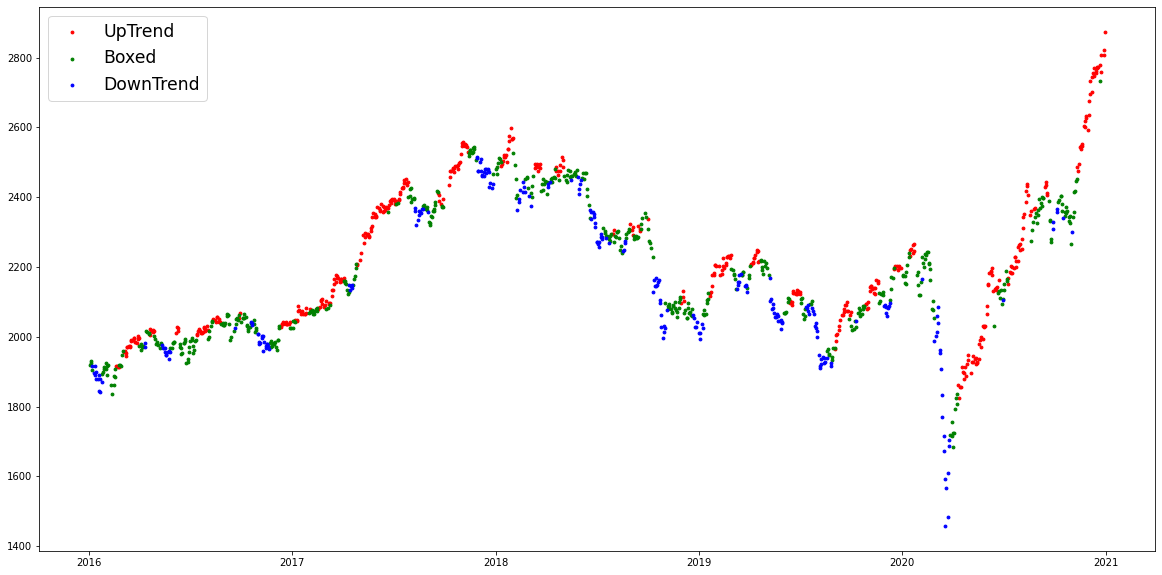

In [9]:
uptrend = df[df['Trend']==2]['Close']
boxed = df[df['Trend']==1]['Close']
downtrend = df[df['Trend']==0]['Close']

plt.figure(figsize=(20,10))
plt.scatter(x=uptrend.index, y=uptrend, color='red', s=8, label='UpTrend')
plt.scatter(x=boxed.index, y=boxed, color='green', s=8, label='Boxed')
plt.scatter(x=downtrend.index, y=downtrend, color='blue', s=8, label='DownTrend')
plt.legend(fontsize='xx-large')
plt.show()

In [11]:
close_ = (df['Close'] - df['Close'].min())/(df['Close'].max() - df['Close'].min())

In [258]:
%%time
close_arr = []

target = df['Trend'][32:]

for i in range(len(df)-32):
    close_temp = close_[i:i+32]
    close_arr.append(close_temp)

close_arr = np.array(close_arr)
target_arr = np.array(target)
print(close_arr.shape)
print(target_arr.shape)

(1195, 32)
(1195,)
CPU times: user 123 ms, sys: 1.03 ms, total: 124 ms
Wall time: 124 ms


In [259]:
print(len(target_arr[target_arr==0]))
print(len(target_arr[target_arr==1]))
print(len(target_arr[target_arr==2]))

229
493
473


In [260]:
gaf_tran = GramianAngularField(image_size=32)
mtf_tran = MarkovTransitionField(image_size=32)

In [261]:
%%time
close_gaf = []

for i in range(close_arr.shape[0]):
    close_new = gaf_tran.transform(close_arr[i].reshape(1,-1))
    close_gaf.append(close_new)

close_gaf = np.array(close_gaf)

close_mtf = []

for i in range(close_arr.shape[0]):
    close_new = mtf_tran.transform(close_arr[i].reshape(1,-1))
    close_mtf.append(close_new)

close_mtf = np.array(close_mtf)

CPU times: user 817 ms, sys: 6.99 ms, total: 824 ms
Wall time: 824 ms


In [262]:
# close_gaf.shape
close_mtf.shape

(1195, 1, 32, 32)

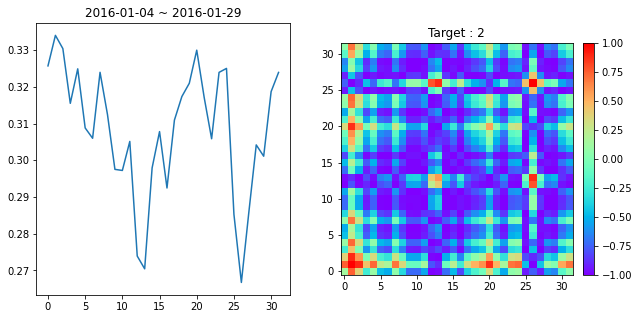

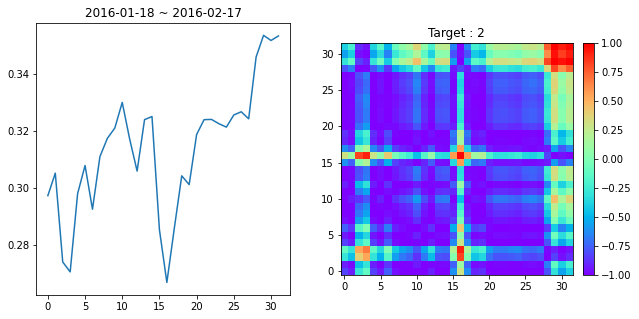

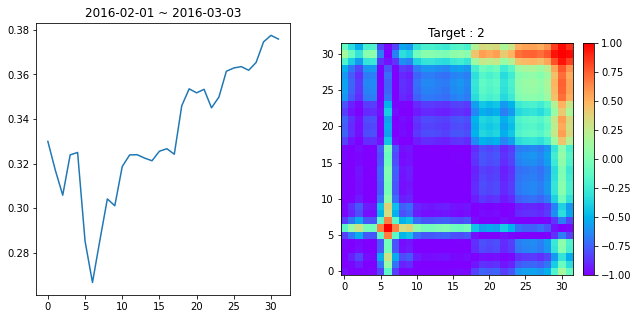

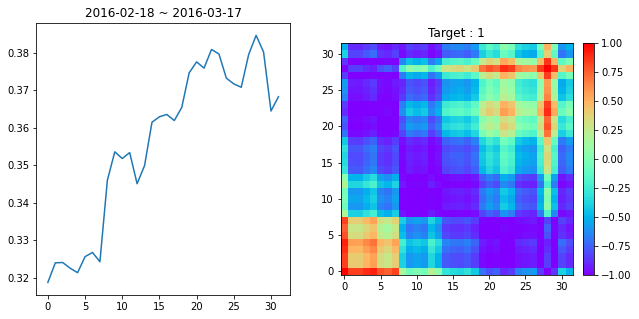

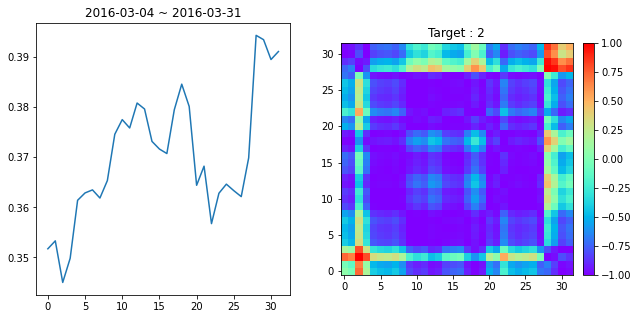

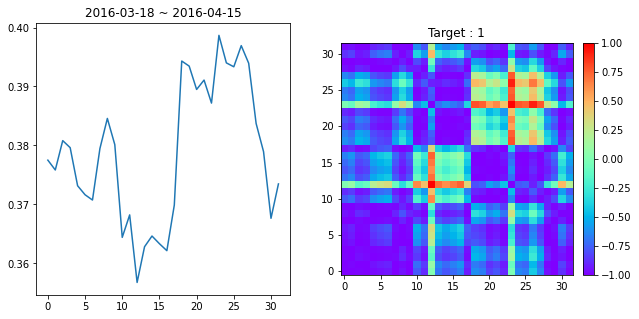

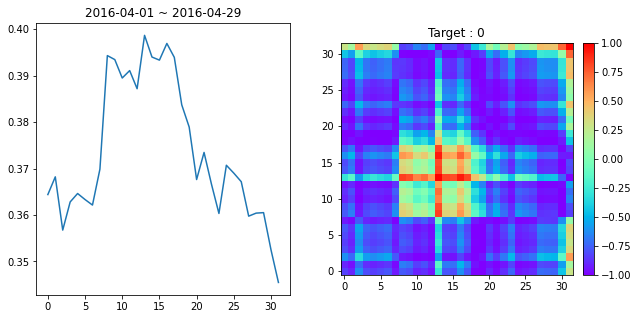

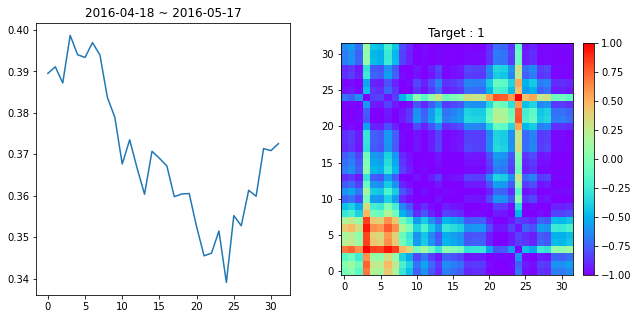

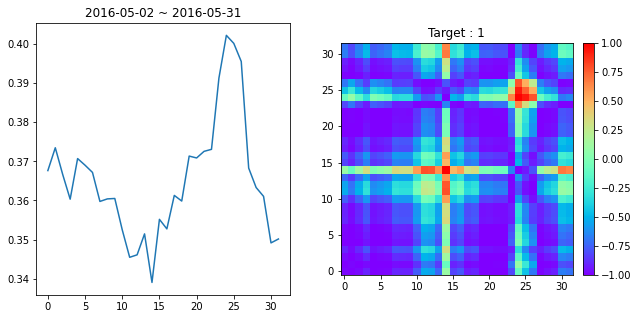

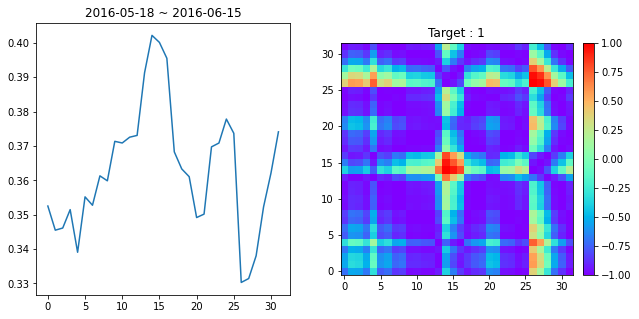

In [263]:
for i in range(0,100,10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(close_arr[i])
    plt.title(str(df.index[i])[:10]+' ~ '+str(df.index[i+19])[:10])
    plt.subplot(1,2,2)
    plt.imshow(close_gaf[i][0], cmap='rainbow', origin='lower')
    plt.colorbar(fraction=0.0457, pad=0.04)
    plt.title('Target : '+str(target_arr[i]))
    plt.show()

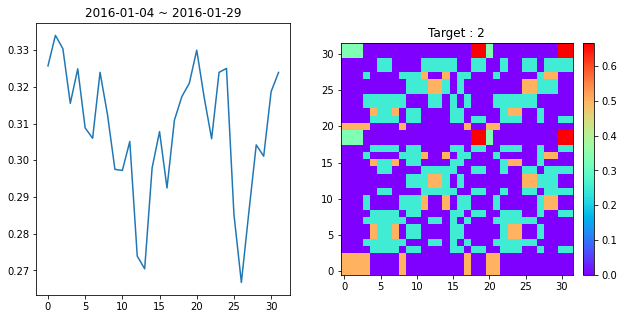

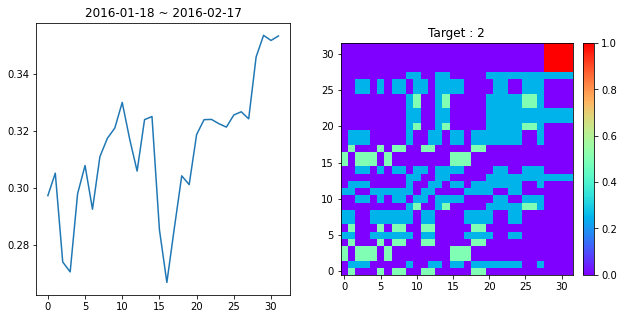

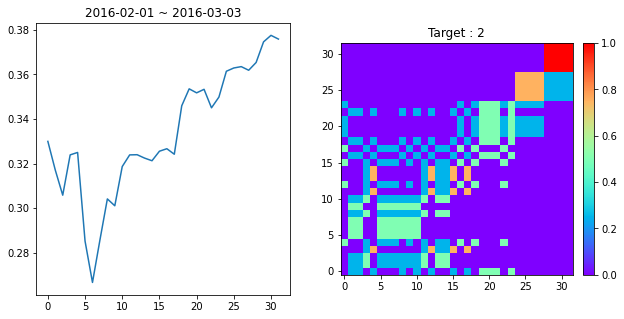

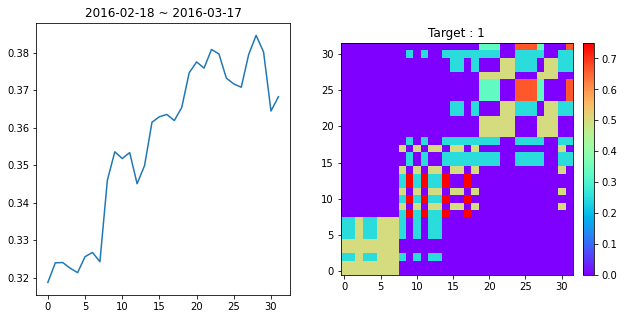

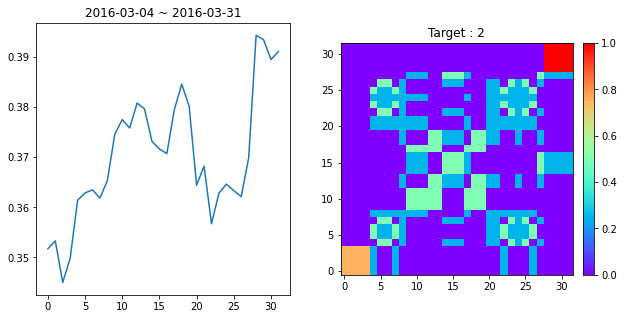

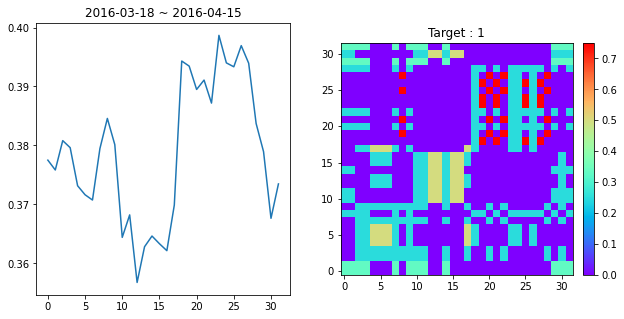

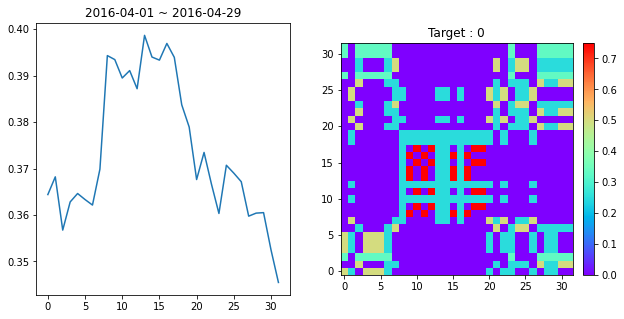

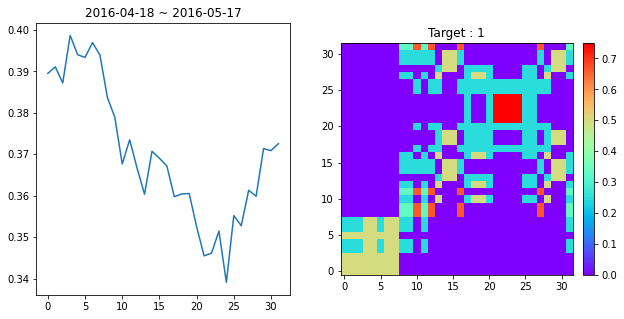

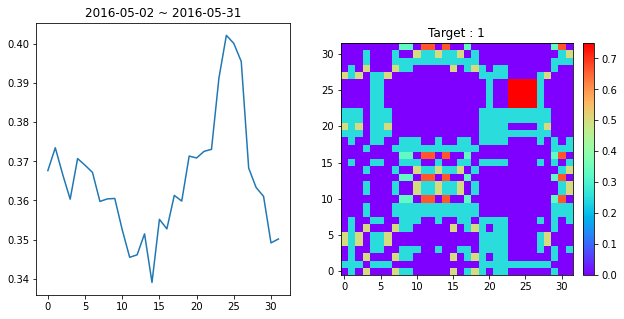

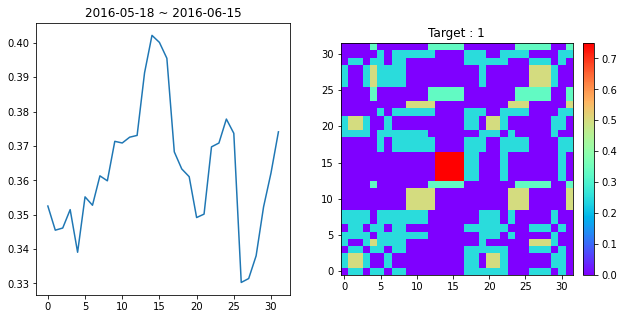

In [264]:
for i in range(0,100,10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(close_arr[i])
    plt.title(str(df.index[i])[:10]+' ~ '+str(df.index[i+19])[:10])
    plt.subplot(1,2,2)
    plt.imshow(close_mtf[i][0], cmap='rainbow', origin='lower')
    plt.colorbar(fraction=0.0457, pad=0.04)
    plt.title('Target : '+str(target_arr[i]))
    plt.show()

In [265]:
# X_data = close_gaf
X_data = close_mtf

In [266]:
X_data.shape

(1195, 1, 32, 32)

In [267]:
split_num = int(len(X_data)*0.7)

X_train = X_data[:split_num]
X_test = X_data[split_num:]

y_train = target_arr[:split_num]
y_test = target_arr[split_num:]

In [268]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(836, 1, 32, 32)
(359, 1, 32, 32)
(836,)
(359,)


In [269]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.Tensor(X_train) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=2, drop_last=True)

X_test_tensor = torch.Tensor(X_test) # transform to torch tensor
y_test_tensor = torch.Tensor(y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=2, drop_last=True)

In [270]:
dataloaders = {}
dataloaders['train']= train_dataloader
dataloaders['test']= test_dataloader
dataset_sizes = {}
dataset_sizes['train']= len(y_train)
dataset_sizes['test']= len(y_test)

In [282]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.7, 0.999), eps=1e-08)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [283]:
inputs, labels = next(iter(dataloaders['train']))

In [284]:
inputs.shape

torch.Size([2, 1, 32, 32])

In [285]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_model_loss = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    loss_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
#                     print(outputs, labels)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_loss = copy.deepcopy(model.state_dict())
                # loss_acc = epoch_acc
            
            # final_model = copy.deepcopy(model.state_dict())
            # final_acc = epoch_acc


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # print('Best val Acc in best train loss: {:4f}'.format(loss_acc))

    # model.load_state_dict(best_model_wts)
    model.load_state_dict(best_model_loss)
    # model.load_state_dict(final_model)

    return model, best_acc

In [286]:
model, acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3400 Acc: 0.4653
test Loss: 1.3963 Acc: 0.3538

Epoch 1/24
----------
train Loss: 1.3197 Acc: 0.4737
test Loss: 1.1475 Acc: 0.4206

Epoch 2/24
----------
train Loss: 1.2581 Acc: 0.4773
test Loss: 1.2952 Acc: 0.3760

Epoch 3/24
----------
train Loss: 1.2457 Acc: 0.4665
test Loss: 1.0780 Acc: 0.3593

Epoch 4/24
----------
train Loss: 1.2405 Acc: 0.4689
test Loss: 1.0504 Acc: 0.3928

Epoch 5/24
----------
train Loss: 1.2204 Acc: 0.4593
test Loss: 1.0370 Acc: 0.3649

Epoch 6/24
----------
train Loss: 1.2091 Acc: 0.4701
test Loss: 1.1334 Acc: 0.3259

Epoch 7/24
----------
train Loss: 1.2103 Acc: 0.4390
test Loss: 1.0386 Acc: 0.4067

Epoch 8/24
----------
train Loss: 1.2175 Acc: 0.4498
test Loss: 1.0428 Acc: 0.4011

Epoch 9/24
----------
train Loss: 1.1721 Acc: 0.4533
test Loss: 1.0690 Acc: 0.3733

Epoch 10/24
----------
train Loss: 1.1793 Acc: 0.4378
test Loss: 1.0761 Acc: 0.3482

Epoch 11/24
----------
train Loss: 1.1611 Acc: 0.4306
test Loss: 1.0532 Acc

In [287]:
df_predict = df.iloc[31:-1]
df_predict['Target'] = target_arr
predict_success = []
pred = []

for i in range(len(X_data)):
    a = model(torch.Tensor(X_data[i]).unsqueeze(0).to(device))
    _, preds = torch.max(a, 1)
    
    pred.append(int(preds))
    
    if preds == target_arr[i]:
        predict_success.append(1)
    else :
        predict_success.append(0)
        
df_predict['Predict'] = pred
df_predict['Success'] = predict_success
df_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Close,High,Low,MA,1_Before,2_Before,3_Before,4_Before,5_Before,Before,Trend,Target,Predict,Success
Date,,,,,,,,,,,,,,
2016-02-19,1916.24,1916.24,1902.24,1895.290000,1,1,1,1,1,5,2,2,0,0
2016-02-22,1916.36,1921.14,1905.85,1896.522667,1,1,1,1,1,5,2,2,0,0
2016-02-23,1914.22,1929.53,1909.79,1897.008000,1,1,1,1,1,5,2,2,0,0
2016-02-24,1912.53,1918.63,1906.19,1897.039333,1,1,1,1,1,5,2,1,0,0
2016-02-25,1918.57,1928.49,1906.99,1896.622667,0,1,1,1,1,4,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,2733.68,2774.22,2733.64,2744.512000,1,1,1,1,1,5,1,2,2,1
2020-12-23,2759.82,2769.08,2716.28,2750.106667,1,1,1,1,1,5,2,2,2,1
2020-12-24,2806.86,2812.16,2762.60,2757.482667,1,1,1,1,1,5,2,2,2,1


In [288]:
df_predict['Trend'].value_counts()

1    493
2    473
0    229
Name: Trend, dtype: int64

In [289]:
df_predict['Predict'].value_counts()

2    628
1    285
0    282
Name: Predict, dtype: int64

In [290]:
df_predict['Success'].value_counts()

0    745
1    450
Name: Success, dtype: int64

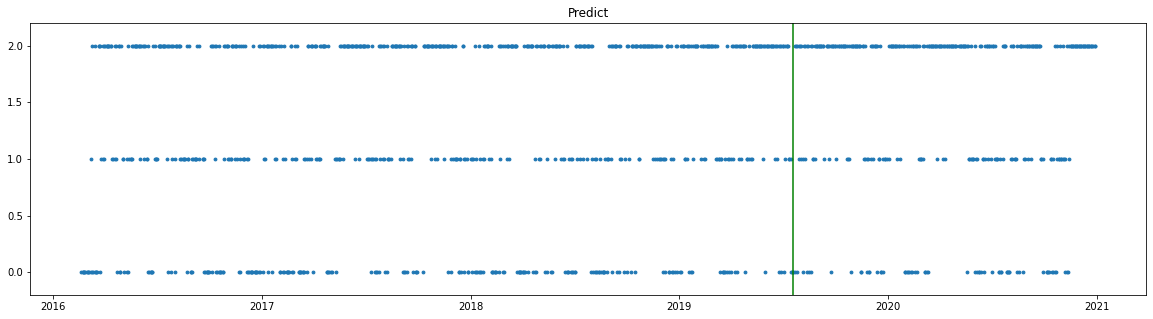

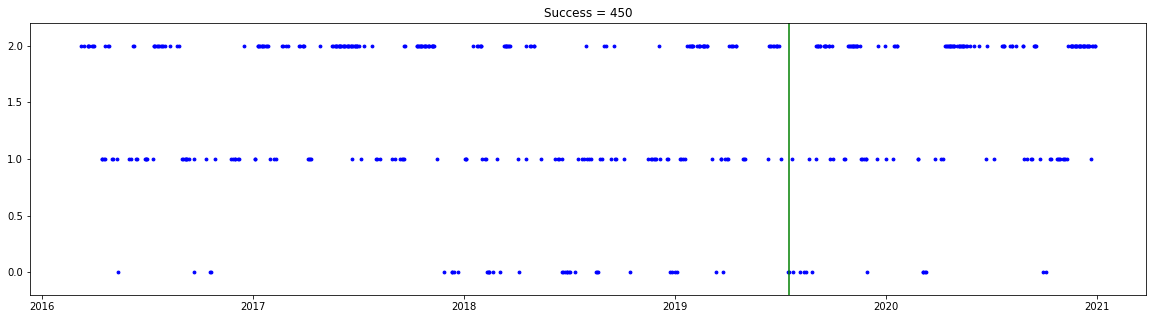

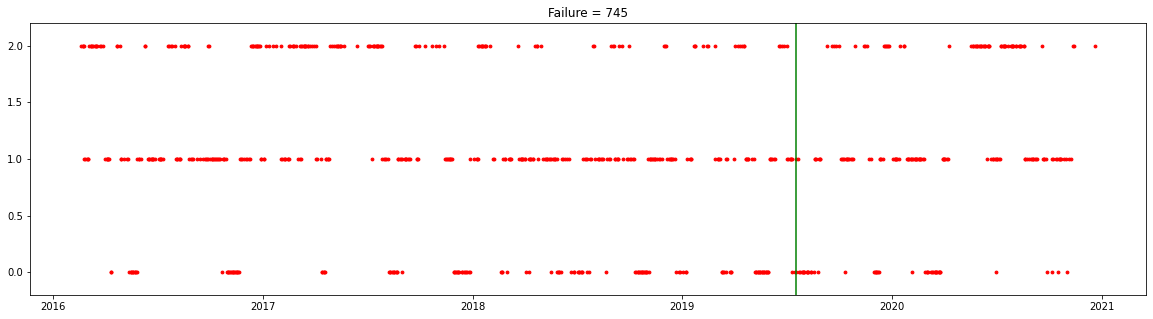

In [291]:
success = df_predict[df_predict['Success']==1]['Trend']
failure = df_predict[df_predict['Success']==0]['Trend']

plt.figure(figsize=(20,5))
plt.scatter(x=df_predict.index, y=df_predict['Predict'], s=8, label='Predict')
plt.axvline(x=df_predict.index[split_num], color='green')
plt.ylim(-0.2, 2.2)
plt.title('Predict')
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(x=success.index, y=success, color='blue', s=8, label='Success')
plt.axvline(x=df_predict.index[split_num], color='green')
plt.ylim(-0.2, 2.2)
plt.title('Success = '+ str(len(success)))
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(x=failure.index, y=failure, color='red', s=8, label='Failure')
plt.axvline(x=df_predict.index[split_num], color='green')
plt.ylim(-0.2, 2.2)
plt.title('Failure = '+ str(len(failure)))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


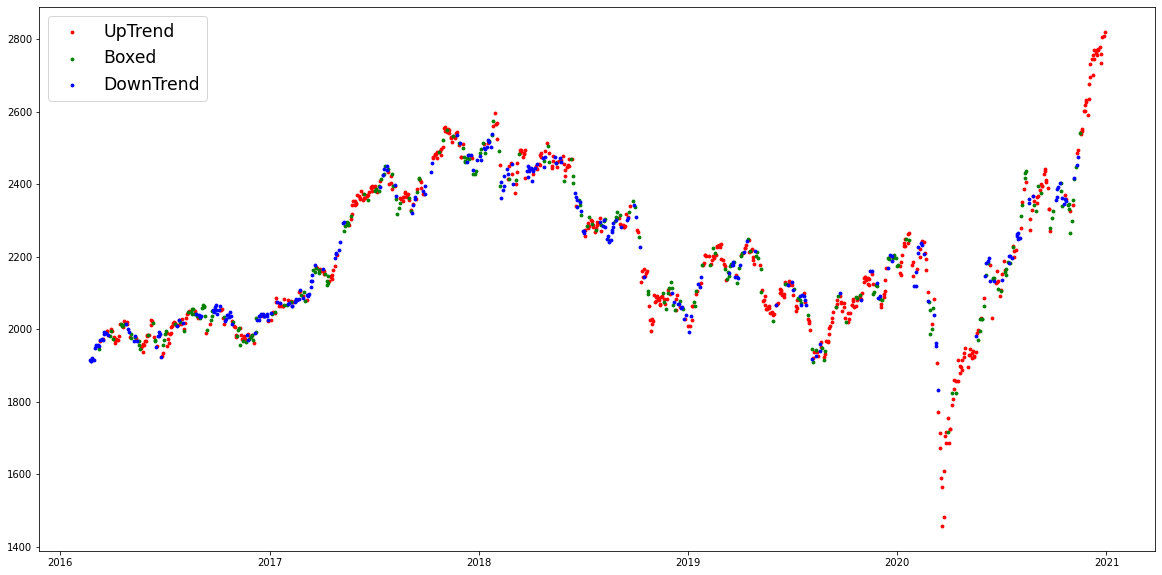

In [292]:
df_predict['Pred_Trend'] = df_predict['Predict'].shift(1)

uptrend = df_predict[df_predict['Pred_Trend']==2]['Close']
boxed = df_predict[df_predict['Pred_Trend']==1]['Close']
downtrend = df_predict[df_predict['Pred_Trend']==0]['Close']

plt.figure(figsize=(20,10))
plt.scatter(x=uptrend.index, y=uptrend, color='red', s=8, label='UpTrend')
plt.scatter(x=boxed.index, y=boxed, color='green', s=8, label='Boxed')
plt.scatter(x=downtrend.index, y=downtrend, color='blue', s=8, label='DownTrend')
plt.legend(fontsize='xx-large')
plt.show()